<a href="https://colab.research.google.com/github/arumshin-dev/python_conda_jupyter/blob/main/codeit/3_5_16_LangGraph_3_ReAct%E1%84%8B%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%8C%E1%85%A5%E1%86%AB%E1%84%90%E1%85%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangGraph 실습 3: Tool 에이전트 (ReAct 패턴)

- LLM이 **스스로 도구를 선택**하는 ReAct 패턴을 이해한다
- `create_react_agent`로 빠르게 에이전트를 만든다
- 내부 동작을 StateGraph로 직접 구현해본다

---

## 핵심 개념: ReAct 패턴

**ReAct = Reasoning + Acting**

```
사용자: "서울 날씨 알려줘, 그리고 23 * 17 계산해줘"

LLM 생각: "날씨 정보가 필요하네 → 날씨 도구 호출"
   → [weather_tool] 호출 → 결과 받음

LLM 생각: "계산도 해야 하네 → 계산기 도구 호출"
   → [calculator_tool] 호출 → 결과 받음

LLM 생각: "이제 답변할 수 있어"
   → 최종 답변 생성
```

LLM이 **어떤 도구를 쓸지 스스로 판단**하고, **필요하면 여러 도구를 연속 호출**합니다.

## 0. 환경 설정

In [ ]:
# 패키지 설치
!pip install -q langchain-openai langgraph langchain-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 12.4 MB/s eta 0:00:00


In [ ]:
# API 키 설정
import os
from getpass import getpass

# API 키 설정
os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key: ")

OpenAI API Key: ··········


## 1. 도구(Tool) 정의

LLM이 사용할 수 있는 도구들을 정의합니다.  
`@tool` 데코레이터를 사용하면 함수가 LLM이 호출 가능한 도구로 변환됩니다.

In [ ]:
from langchain_core.tools import tool
from typing import Annotated
import random


@tool
def get_weather(city: Annotated[str, "도시 이름 (예: 서울, 부산)"]) -> str:
    """특정 도시의 현재 날씨를 조회합니다."""
    # 시뮬레이션용 가짜 데이터
    weather_data = {
        "서울": {"temp": 22, "condition": "맑음", "humidity": 45},
        "부산": {"temp": 25, "condition": "흐림", "humidity": 65},
        "제주": {"temp": 27, "condition": "비", "humidity": 80},
    }

    if city in weather_data:
        data = weather_data[city]
        return f"{city} 날씨: {data['temp']}°C, {data['condition']}, 습도 {data['humidity']}%"
    else:
        return f"{city}의 날씨 정보를 찾을 수 없습니다."


@tool
def calculator(
    expression: Annotated[str, "계산할 수식 (예: 23 * 17)"]
) -> str:
    """수학 계산을 수행합니다. 사칙연산과 거듭제곱을 지원합니다."""
    try:
        # 안전한 eval (숫자와 연산자만 허용)
        allowed_chars = set("0123456789+-*/() .")
        if not all(c in allowed_chars for c in expression):
            return "오류: 허용되지 않은 문자가 포함되어 있습니다."

        result = eval(expression)
        return f"{expression} = {result}"
    except Exception as e:
        return f"계산 오류: {str(e)}"


@tool
def search_restaurant(
    location: Annotated[str, "검색할 지역"],
    cuisine: Annotated[str, "음식 종류 (한식, 중식, 일식 등)"] = "전체"
) -> str:
    """특정 지역의 맛집을 검색합니다."""
    # 시뮬레이션용 가짜 데이터
    restaurants = {
        "강남": [
            {"name": "봉피양", "cuisine": "한식", "rating": 4.5},
            {"name": "딘타이펑", "cuisine": "중식", "rating": 4.3},
            {"name": "스시코우지", "cuisine": "일식", "rating": 4.7},
        ],
        "홍대": [
            {"name": "연남토마", "cuisine": "한식", "rating": 4.2},
            {"name": "이치란", "cuisine": "일식", "rating": 4.4},
        ]
    }

    if location not in restaurants:
        return f"{location} 지역의 맛집 정보가 없습니다."

    results = restaurants[location]
    if cuisine != "전체":
        results = [r for r in results if r["cuisine"] == cuisine]

    if not results:
        return f"{location}에서 {cuisine} 맛집을 찾을 수 없습니다."

    output = f"{location} 맛집 추천:\n"
    for r in results:
        output += f"- {r['name']} ({r['cuisine']}) ⭐{r['rating']}\n"
    return output


# 도구 목록
tools = [get_weather, calculator, search_restaurant]

print("사용 가능한 도구:")
for t in tools:
    print(f"  - {t.name}: {t.description}")

사용 가능한 도구:
  - get_weather: 특정 도시의 현재 날씨를 조회합니다.
  - calculator: 수학 계산을 수행합니다. 사칙연산과 거듭제곱을 지원합니다.
  - search_restaurant: 특정 지역의 맛집을 검색합니다.


## 2. 방법 1: `create_react_agent` (간편 버전)

LangGraph가 제공하는 `create_react_agent`를 사용하면  
**단 몇 줄로** ReAct 에이전트를 만들 수 있습니다.

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# LLM 설정
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# ReAct 에이전트 생성 (단 1줄!)
react_agent = create_react_agent(llm, tools)

print("ReAct 에이전트 생성 완료!")

ReAct 에이전트 생성 완료!


/tmp/ipython-input-3746341224.py:8: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_agent = create_react_agent(llm, tools)


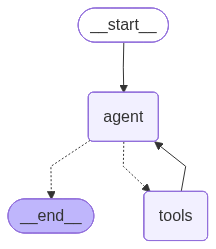

In [ ]:
# 그래프 시각화
from IPython.display import Image, display

display(Image(react_agent.get_graph().draw_mermaid_png()))

In [ ]:
# 테스트 1: 단일 도구 사용
print("=" * 60)
print("테스트 1: 날씨 조회")
print("=" * 60)

result = react_agent.invoke({
    "messages": [("human", "서울 날씨 어때?")]
})

# 마지막 메시지 출력
print(f"\n  답변: {result['messages'][-1].content}")

테스트 1: 날씨 조회

  답변: 서울의 현재 날씨는 22°C로 맑고, 습도는 45%입니다.


In [ ]:
# 테스트 2: 다중 도구 사용
print("=" * 60)
print("테스트 2: 복합 질문 (날씨 + 계산 + 맛집)")
print("=" * 60)

result = react_agent.invoke({
    "messages": [("human",
        "서울 날씨 알려주고, 1234 * 5678 계산해줘. "
        "그리고 강남에 맛있는 일식집 추천해줘."
    )]
})

print(f"\n  답변: {result['messages'][-1].content}")

테스트 2: 복합 질문 (날씨 + 계산 + 맛집)

  답변: 서울의 현재 날씨는 22°C, 맑음, 습도 45%입니다.

계산 결과: 1234 * 5678 = 7,006,652입니다.

강남에 추천하는 맛있는 일식집은 "스시고지"입니다.


In [ ]:
# 스트리밍으로 내부 동작 확인
print("=" * 60)
print("스트리밍: 내부 동작 추적")
print("=" * 60)

for step in react_agent.stream({
    "messages": [("human", "부산 날씨랑 23 + 45 * 2 계산해줘")]
}):
    for node_name, output in step.items():
        print(f"\n 노드: {node_name}")
        if "messages" in output:
            for msg in output["messages"]:
                if hasattr(msg, "tool_calls") and msg.tool_calls:
                    for tc in msg.tool_calls:
                        print(f"   도구 호출: {tc['name']}({tc['args']})")
                elif hasattr(msg, "content") and msg.content:
                    content = msg.content[:100] + "..." if len(msg.content) > 100 else msg.content
                    print(f"   내용: {content}")

스트리밍: 내부 동작 추적

 노드: agent
   도구 호출: get_weather({'city': '부산'})
   도구 호출: calculator({'expression': '23 + 45 * 2'})

 노드: tools
   내용: 부산 날씨: 25°C, 흐림, 습도 65%

 노드: tools
   내용: 23 + 45 * 2 = 113

 노드: agent
   내용: 부산의 현재 날씨는 25°C, 맑고 습도는 65%입니다.

또한, 23 + 45 * 2의 계산 결과는 113입니다.


---

## 3. 방법 2: StateGraph로 직접 구현 (상세 버전)

`create_react_agent`의 내부 동작을 이해하기 위해  
**StateGraph로 직접** ReAct 패턴을 구현해봅니다.

In [ ]:
from typing import TypedDict, Annotated, Literal
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# LLM에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)

In [ ]:
# ============================================
# [1] State 정의
# ============================================

class AgentState(TypedDict):
    # add_messages: 메시지를 덮어쓰지 않고 추가
    messages: Annotated[list[BaseMessage], add_messages]

In [ ]:
# ============================================
# [2] Node 정의
# ============================================

def call_llm(state: AgentState) -> dict:
    """LLM을 호출하여 다음 행동 결정"""
    print("\n  [call_llm] LLM 호출 중...")

    messages = state["messages"]
    response = llm_with_tools.invoke(messages)

    if response.tool_calls:
        print(f"   → 도구 호출 결정: {[tc['name'] for tc in response.tool_calls]}")
    else:
        print("   → 최종 답변 생성")

    return {"messages": [response]}


def call_tools(state: AgentState) -> dict:
    """도구 실행"""
    print("\n  [call_tools] 도구 실행 중...")

    # 마지막 AI 메시지에서 tool_calls 추출
    last_message = state["messages"][-1]
    tool_calls = last_message.tool_calls

    # 도구 이름 → 도구 함수 매핑
    tool_map = {t.name: t for t in tools}

    results = []
    for tc in tool_calls:
        tool_name = tc["name"]
        tool_args = tc["args"]

        print(f"   실행: {tool_name}({tool_args})")

        # 도구 실행
        tool_result = tool_map[tool_name].invoke(tool_args)
        print(f"   결과: {tool_result}")

        # ToolMessage로 변환
        results.append(
            ToolMessage(
                content=str(tool_result),
                tool_call_id=tc["id"]
            )
        )

    return {"messages": results}

In [ ]:
# ============================================
# [3] Router 정의 - 다음 노드를 결정하는 "교통 경찰"
# ============================================
# - 조건부 엣지(Conditional Edge)에서 호출됨
# - 반환값 = 다음에 실행할 노드 이름
# - if-else 분기를 그래프 흐름으로 표현하는 핵심!

def should_continue(state: AgentState) -> Literal["call_tools", "__end__"]:
    """도구 호출이 필요한지 판단"""
    last_message = state["messages"][-1]

    # tool_calls가 있으면 도구 실행
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "call_tools"

    # 없으면 종료
    return "__end__"

In [ ]:
# ============================================
# [4] 그래프 조립
# ============================================

workflow = StateGraph(AgentState)

# 노드 등록
workflow.add_node("call_llm", call_llm)
workflow.add_node("call_tools", call_tools)

# 엣지 연결
workflow.add_edge(START, "call_llm")

# 조건부 엣지: LLM 응답에 따라 분기
workflow.add_conditional_edges(
    source="call_llm",
    path=should_continue,
    path_map={
        "call_tools": "call_tools",
        "__end__": END
    }
)

# 도구 실행 후 → 다시 LLM (루프!)
workflow.add_edge("call_tools", "call_llm")

# 컴파일
custom_agent = workflow.compile()

print("커스텀 ReAct 에이전트 생성 완료!")

커스텀 ReAct 에이전트 생성 완료!


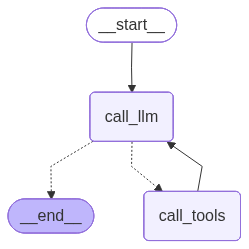

In [ ]:
# 그래프 시각화
display(Image(custom_agent.get_graph().draw_mermaid_png()))

In [ ]:
# 커스텀 에이전트 테스트
print("=" * 60)
print("커스텀 ReAct 에이전트 테스트")
print("=" * 60)

result = custom_agent.invoke({
    "messages": [HumanMessage(content="제주 날씨 알려주고, 100/4 계산해줘")]
})

print("\n" + "=" * 60)
print("----- 최종 답변")
print("=" * 60)
print(result["messages"][-1].content)

커스텀 ReAct 에이전트 테스트

  [call_llm] LLM 호출 중...
   → 도구 호출 결정: ['get_weather', 'calculator']

  [call_tools] 도구 실행 중...
   실행: get_weather({'city': '제주'})
   결과: 제주 날씨: 27°C, 비, 습도 80%
   실행: calculator({'expression': '100/4'})
   결과: 100/4 = 25.0

  [call_llm] LLM 호출 중...
   → 최종 답변 생성

----- 최종 답변
제주의 현재 날씨는 27°C이며, 비가 오고 습도는 80%입니다. 

또한, 100을 4로 나누면 25.0입니다.


---

## 핵심

### ReAct 패턴 흐름

```
       ┌──────────────────────────┐
       │                          │
       ▼                          │ (도구 결과 전달)
  [call_llm] ──(tool_calls)──> [call_tools]
       │
       │ (no tool_calls)
       ▼
      END
```

### 두 가지 구현 방법

| 방법 | 장점 | 단점 |
|------|------|------|
| `create_react_agent` | 간단, 빠름 | 커스터마이징 제한 |
| StateGraph 직접 구현 | 완전한 제어 | 코드량 많음 |

---

## 혼자해보기 실습

### 문제 1: 새 도구 추가
`translate` 도구를 만들어 에이전트에 추가해보세요.  
- 입력: 텍스트, 타겟 언어
- 출력: 번역된 텍스트 (시뮬레이션)
